# Visualizing What I'm Listening To With Spotify and Last.fm

This was a short little project to see what exactly I was listening to at certain times. For more of a write-up, see [my website](http://ben-tanen.github.io).

### Setup

Basic setup: import modules / libraries and define a helper function for finding the nth substring in a string (used for parsing the text file)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import datetime

# function used to parse track text file
def find_nth_substring(string, substring, n):
    parts = string.split(substring, n+1)
    if len(parts)<=n+1:
        return -1
    return len(string)-len(parts[-1])-len(substring)

### Parse Exported Last.fm Data

Using [this script](https://gist.github.com/bitmorse/5201491), I was able to pump all of the scrobbling data from my Last.fm account to a text file. Unfortunately, it was not formatted in a particularly friendly way, so I had to parse it into a DataFrame.

Each line of track information was formated like: *"1440990398\tGangsta Gangsta\tN.W.A\tStraight Outta Compton (2002 - Remaster)\tda8289db-dcdd-403b-b7bb-c93342edfe0e\t3a54bffa-2314-44a2-927b-"*


In [2]:
# open file and split into individual track line
text_file = open("exported_tracks.txt", "rb")
imported_tracks = text_file.readlines()

# make dataframe to hold all track data
tracks_df = pd.DataFrame(columns = ['Title', 'Artist', 'Album', 'Date'])

# push track data into dataframe
for track in imported_tracks:
    track_title  = track[find_nth_substring(track,"\t",0)+1:find_nth_substring(track,"\t",1)]
    track_artist = track[find_nth_substring(track,"\t",1)+1:find_nth_substring(track,"\t",2)]
    track_album  = track[find_nth_substring(track,"\t",2)+1:find_nth_substring(track,"\t",3)]
    track_date   = time.localtime(int(track[:find_nth_substring(track,"\t",0)]))
    tracks_df.loc[tracks_df.shape[0]] = [track_title, track_artist, track_album, track_date]
    
# output results to csv file
tracks_df.to_csv('tracks.csv')

### Analyze Data

This is really simple analysis. More or less filter the tracks dataset for rows that meet the conditions (either over the short span or the whole time period with the correct artist), note the size of the filtered dataset and then graph it.

In [4]:
# bar graph (overall plays)
def generate_bargraph():
    # make df to hold plays
    bar_num_plays = pd.DataFrame(index = artists, columns = ["Plays"])

    # loop through artists and filter to meet conditions
    for i in range(len(artists)):
        tracks_df_sub = tracks_df[tracks_df.Artist == artists[i]][tracks_df.Date >= t1][tracks_df.Date <= t2]
        bar_num_plays.loc[artists[i]] = tracks_df_sub.shape[0]

    # graph the output
    graph_title = "Total Plays (between " + start_date + " & " + end_date + ")"
    bar_num_plays.plot(kind = 'bar', title = graph_title, figsize = graph_size)

In [5]:
# line graph (plays per span of time)
def generate_linegraph():
    # setup time series to work over
    num_periods = ((time.mktime(t2) - time.mktime(t1)) / (60 * 60 * 24 * daily_span)) + 1
    date_series = pd.date_range(start_date, periods = num_periods, freq = (str(daily_span) + "D"))
    
    # make df to hold plays
    line_num_plays = pd.DataFrame(index = date_series, columns = artists)

    # for each artist and each date, filter for correct conditions and add plays
    for artist in artists:
        for date in date_series:
            date_struct = time.strptime(str(date), "%Y-%m-%d %H:%M:%S")
            nxt_date_struct = time.strptime(str(date + 1), "%Y-%m-%d %H:%M:%S")
            tracks_df_sub = tracks_df[tracks_df.Artist == artist][tracks_df.Date >= date_struct][tracks_df.Date < nxt_date_struct]
            line_num_plays.loc[date, artist] = tracks_df_sub.shape[0]

    # graph the output
    graph_title = "Plays (between " + start_date + " & " + end_date + " @ " + str(daily_span) + " day spans)"
    line_num_plays.plot(title = graph_title, figsize = graph_size)

### Set Options and and View Graphs

This is just final options setting for the graphs (date ranges, artists to analyze, and how many days to include in the line graphs span). From there, it's just calling those suckers.

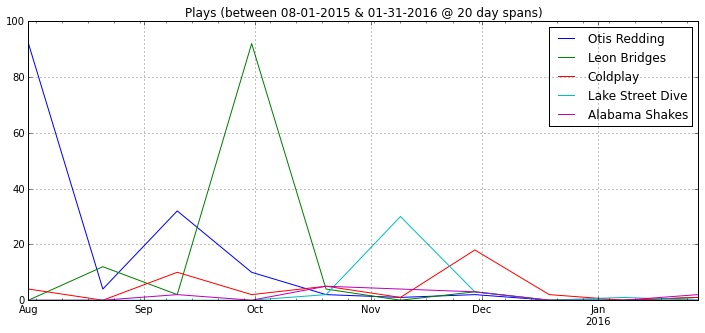

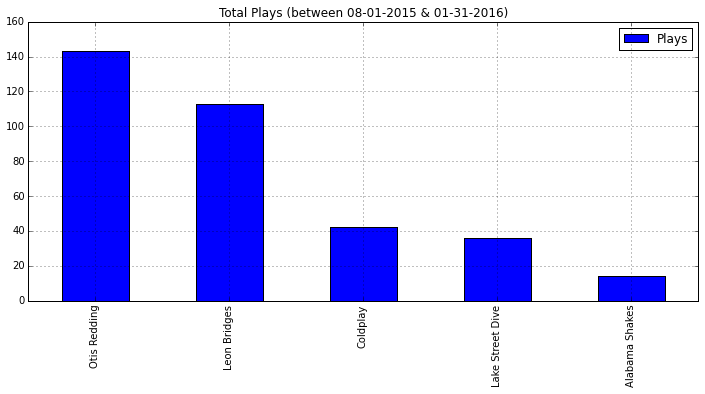

In [8]:
start_date = '08-01-2015'
end_date   = '01-31-2016'
# artists    = ['Cold War Kids', 'NEEDTOBREATHE', 'Ben Howard', 'Tom Odell', 'Ben Folds', 'AWOLNATION', 'Wild Child']
artists    = ['Otis Redding', 'Leon Bridges', 'Coldplay', 'Lake Street Dive', 'Alabama Shakes']
daily_span = 20
graph_size = (12, 5)

t1 = time.strptime(start_date, "%m-%d-%Y")
t2 = time.strptime(end_date, "%m-%d-%Y")

generate_linegraph()
generate_bargraph()